In [1]:
import os, glob
import torch
import whisper


# SPEECH TO TEXT

In [2]:
model = whisper.load_model("base")
print("Model loaded successfully")

100%|███████████████████████████████████████| 139M/139M [00:22<00:00, 6.45MiB/s]


Model loaded successfully


In [7]:
input_folder = "/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/HC_AH/"
output_folder = "/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/output"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

unwanted_words = ['um,']

for filename in os.listdir(input_folder):
    if filename.endswith(".wav"):
        audio_path = os.path.join(input_folder, filename)
        result = model.transcribe(audio_path, language="en")

        transcript_path = os.path.join(output_folder, filename.replace(".wav", ".txt"))
        with open(transcript_path, "w") as f:
            f.write(result["text"])

In [10]:
input_folder = "/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/PD_AH/"
output_folder = "/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/output"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

unwanted_words = ['um,']

for filename in os.listdir(input_folder):
    if filename.endswith(".wav"):
        audio_path = os.path.join(input_folder, filename)
        result = model.transcribe(audio_path, language="en")

        transcript_path = os.path.join(output_folder, filename.replace(".wav", ".txt"))
        with open(transcript_path, "w") as f:
            f.write(result["text"])

# Mel-Spectrogram Extraction


In [11]:
import os
from pathlib import Path
import numpy as np
import librosa

# ========= CONFIG =========
AUDIO_DIR = Path("/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/HC_AH")   # folder with audio files (can have subfolders)
OUT_DIR   = Path("/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/mel-spectrogram_output")            # where .npy mel files will be written

SR          = 16000      # sample rate (Whisper uses 16 kHz)
N_MELS      = 80         # Whisper = 80 mel bins
N_FFT       = 400        # ~25 ms window at 16 kHz
HOP_LENGTH  = 160        # ~10 ms hop at 16 kHz
WIN_LENGTH  = 400        # match N_FFT window length
FMIN        = 0
FMAX        = SR // 2    # 8000 for 16 kHz
POWER       = 2.0        # power mel (magnitude^2) before dB
MONO        = True       # convert to mono

# Which file extensions to include
EXTS = {".wav"}

# ==========================

def find_audio_files(root: Path):
    files = []
    for p in root.rglob("*"):
        if p.suffix.lower() in EXTS and p.is_file():
            files.append(p)
    return files

def ensure_dir(path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)

def extract_logmel(y: np.ndarray, sr: int) -> np.ndarray:
    # Mel spectrogram
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX,
        power=POWER,
        center=True,           # librosa default; OK for most use cases
        window="hann",
    )
    # Convert to log-mel dB
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.astype(np.float32)

def main():
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    audio_files = find_audio_files(AUDIO_DIR)
    print(f"Found {len(audio_files)} audio files under {AUDIO_DIR}")

    for i, src in enumerate(sorted(audio_files), 1):
        # preserve subfolder structure, replace extension with .npy
        rel = src.relative_to(AUDIO_DIR)
        dst = (OUT_DIR / rel).with_suffix(".npy")
        ensure_dir(dst)

        # skip if already processed
        if dst.exists():
            print(f"[{i}/{len(audio_files)}] Skip (exists): {dst}")
            continue

        try:
            # load and resample
            y, sr = librosa.load(src, sr=SR, mono=MONO)
            mel = extract_logmel(y, sr)
            np.save(dst, mel)
            print(f"[{i}/{len(audio_files)}] Saved: {dst}  shape={mel.shape}")
        except Exception as e:
            print(f"[{i}/{len(audio_files)}] ERROR: {src} -> {e}")

if __name__ == "__main__":
    main()


Found 41 audio files under /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/HC_AH
[1/41] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/mel-spectrogram_output/AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5.npy  shape=(80, 374)
[2/41] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/mel-spectrogram_output/AH_114S_A89F3548-0B61-4770-B800-2E26AB3908B6.npy  shape=(80, 227)
[3/41] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/mel-spectrogram_output/AH_121A_BD5BA248-E807-4CB9-8B53-47E7FFE5F8E2.npy  shape=(80, 287)
[4/41] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/mel-spectrogram_output/AH_123G_559F0706-2238-447C-BA39-DB5933BA619D.npy  shape=(80, 287)
[5/41] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/mel-spectrogram_output/AH_195B_39DA6A45-F4CC-492A-80D4-FB79049ACC22.npy  shape=(80, 422)
[6/41] Saved: /mnt/d/Roshidat_Ms

In [12]:
import os
from pathlib import Path
import numpy as np
import librosa

# ========= CONFIG =========
AUDIO_DIR = Path("/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/PD_AH")   # folder with audio files (can have subfolders)
OUT_DIR   = Path("/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/mel-spectrogram_output")            # where .npy mel files will be written

SR          = 16000      # sample rate (Whisper uses 16 kHz)
N_MELS      = 80         # Whisper = 80 mel bins
N_FFT       = 400        # ~25 ms window at 16 kHz
HOP_LENGTH  = 160        # ~10 ms hop at 16 kHz
WIN_LENGTH  = 400        # match N_FFT window length
FMIN        = 0
FMAX        = SR // 2    # 8000 for 16 kHz
POWER       = 2.0        # power mel (magnitude^2) before dB
MONO        = True       # convert to mono

# Which file extensions to include
EXTS = {".wav"}

# ==========================

def find_audio_files(root: Path):
    files = []
    for p in root.rglob("*"):
        if p.suffix.lower() in EXTS and p.is_file():
            files.append(p)
    return files

def ensure_dir(path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)

def extract_logmel(y: np.ndarray, sr: int) -> np.ndarray:
    # Mel spectrogram
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX,
        power=POWER,
        center=True,           # librosa default; OK for most use cases
        window="hann",
    )
    # Convert to log-mel dB
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.astype(np.float32)

def main():
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    audio_files = find_audio_files(AUDIO_DIR)
    print(f"Found {len(audio_files)} audio files under {AUDIO_DIR}")

    for i, src in enumerate(sorted(audio_files), 1):
        # preserve subfolder structure, replace extension with .npy
        rel = src.relative_to(AUDIO_DIR)
        dst = (OUT_DIR / rel).with_suffix(".npy")
        ensure_dir(dst)

        # skip if already processed
        if dst.exists():
            print(f"[{i}/{len(audio_files)}] Skip (exists): {dst}")
            continue

        try:
            # load and resample
            y, sr = librosa.load(src, sr=SR, mono=MONO)
            mel = extract_logmel(y, sr)
            np.save(dst, mel)
            print(f"[{i}/{len(audio_files)}] Saved: {dst}  shape={mel.shape}")
        except Exception as e:
            print(f"[{i}/{len(audio_files)}] ERROR: {src} -> {e}")

if __name__ == "__main__":
    main()


Found 40 audio files under /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/PD_AH
[1/40] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/mel-spectrogram_output/AH_545616858-3A749CBC-3FEB-4D35-820E-E45C3E5B9B6A.npy  shape=(80, 549)
[2/40] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/mel-spectrogram_output/AH_545622717-461DFFFE-54AF-42AF-BA78-528BD505D624.npy  shape=(80, 303)
[3/40] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/mel-spectrogram_output/AH_545622718-C052AD58-5E6B-4ADC-855C-F76B66BAFA6E.npy  shape=(80, 172)
[4/40] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/mel-spectrogram_output/AH_545622719-52C23861-6E0D-41E0-A3D8-9358C28C019B.npy  shape=(80, 549)
[5/40] Saved: /mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/mel-spectrogram_output/AH_545622720-E1486AF6-8C95-47EB-829B-4D62698C987A.npy  shape=(80, 369)
[6/40] 

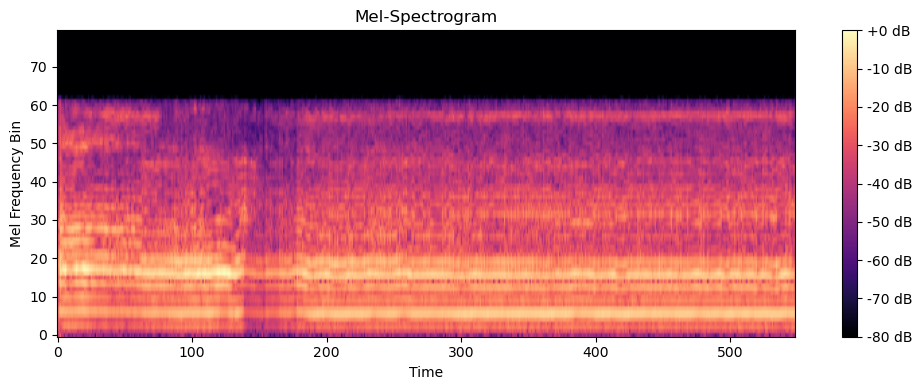

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Path to a saved mel-spectrogram .npy file
mel_path = "/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/PD_AH/PD_mel-spectrogram_output/AH_545616858-3A749CBC-3FEB-4D35-820E-E45C3E5B9B6A.npy"  # Change to your actual file

# Load the mel-spectrogram
mel = np.load(mel_path)

# Plot the mel-spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel, aspect="auto", origin="lower", cmap="magma")
plt.title("Mel-Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bin")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

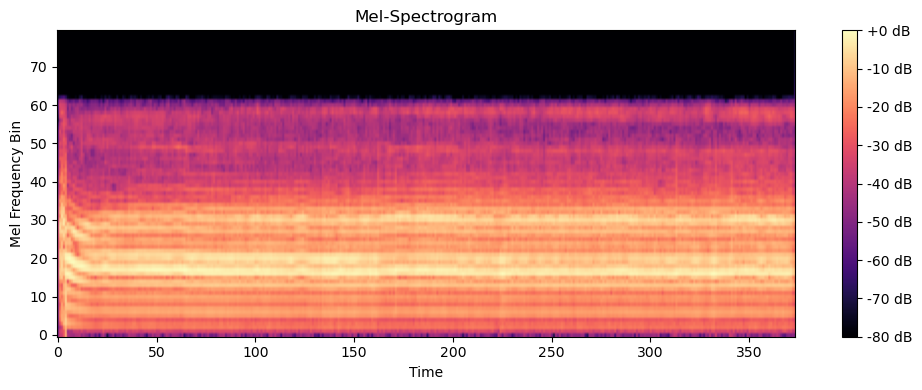

In [14]:
# Path to a saved mel-spectrogram .npy file
mel_path = "/mnt/d/Roshidat_Msc_Project/Audio_parkinson/voicesamplesdataset/HC_AH/HC_mel-spectrogram_output/AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5.npy"  # Change to your actual file

# Load the mel-spectrogram
mel = np.load(mel_path)

# Plot the mel-spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel, aspect="auto", origin="lower", cmap="magma")
plt.title("Mel-Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bin")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()